<a href="https://colab.research.google.com/github/mishcheek/practical-python/blob/master/Final_SMAD_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
import datetime
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


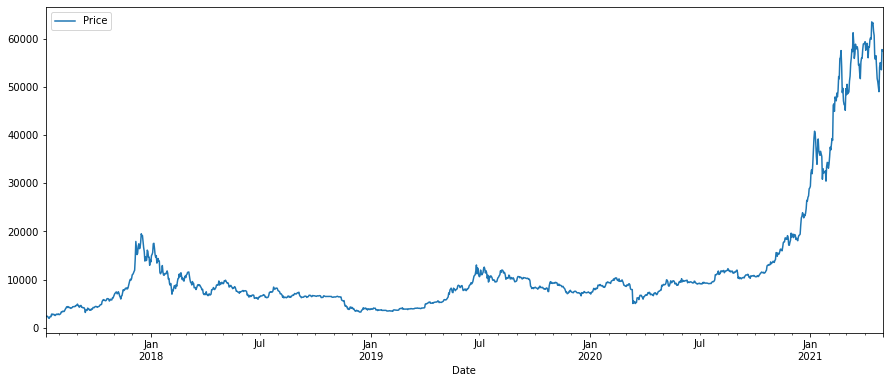

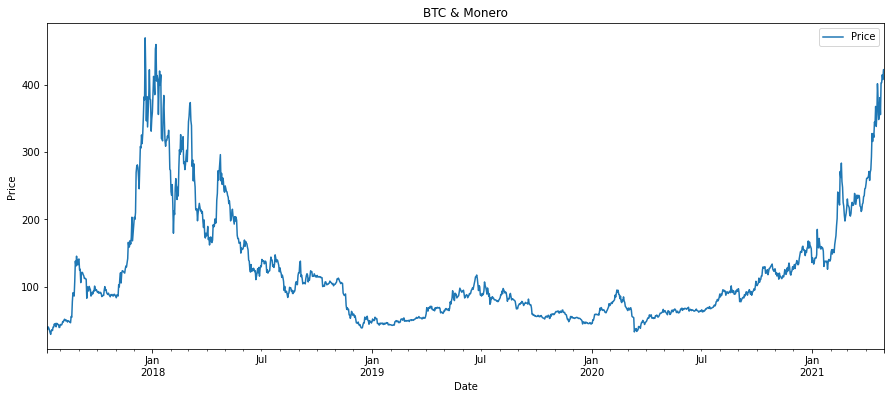

In [3]:
btc_price = pd.read_csv('/content/drive/MyDrive/data/BTC.csv', parse_dates=True, usecols=['Date', 'Price'], na_values=['nan'], index_col=0)
btc_sentiment = pd.read_csv('/content/drive/MyDrive/data/BTC_sentiment.csv', parse_dates=True, usecols=['Date', 'Sentiment'], na_values=['nan'], index_col=0)

monero_price = pd.read_csv('/content/drive/MyDrive/data/Monero.csv', parse_dates=True, usecols=['Date', 'Price'], na_values=['nan'], index_col=0)
monero_sentiment = pd.read_csv('/content/drive/MyDrive/data/Monero_sentiment.csv', parse_dates=True, usecols=['Date', 'Sentiment'], na_values=['nan'], index_col=0)

df = pd.read_csv('/content/drive/MyDrive/data/BTC.csv', parse_dates=True, usecols=['Date', 'Price'], na_values=['nan'])
dates = pd.to_datetime(df['Date'])

btc_price[['Price']].plot(figsize=(15, 6))
monero_price[['Price']].plot(figsize=(15, 6))
plt.ylabel("Price")
plt.title("BTC & Monero")
plt.show()



In [4]:
btc_df = btc_price[['Price']].join(btc_sentiment[['Sentiment']])
xmr_df = monero_price[['Price']].join(monero_sentiment[['Sentiment']])
dataset_size = len(btc_df)

# Fill the missing data points
btc_df.fillna(method='ffill', inplace=True)
xmr_df.fillna(method='ffill', inplace=True)

scaler = MinMaxScaler(feature_range=(-1, 1))

btc_df = scaler.fit_transform(btc_df)
xmr_df = scaler.fit_transform(xmr_df)

# len(xmr_df), xmr_df
# len(btc_df), btc_df

In [5]:
n_future = 1   # Number of days we want to predict into the future
look_back = 14     # Number of past days we want to use to predict the future

from sklearn.model_selection import train_test_split

def prepare_data(df, look_back, n_future):
    """Create train & test data."""

    X_train = []
    y_train = []
    
    for i in range(look_back, len(df) - n_future + 1):
      X_train.append(df[i - look_back:i, 0:df.shape[1]])
      y_train.append(df[i + n_future - 1:i + n_future, 0])
    
    X_train, y_train = np.array(X_train), np.array(y_train)

    return X_train, y_train

X_train_btc, y_train_btc = prepare_data(btc_df, look_back, n_future)
X_train_xmr, y_train_xmr = prepare_data(xmr_df, look_back, n_future)

X_train_btc, X_test_btc, y_train_btc, y_test_btc = train_test_split(X_train_btc, y_train_btc, test_size=0.2, shuffle=False)
X_train_xmr, X_test_xmr, y_train_xmr, y_test_xmr = train_test_split(X_train_xmr, y_train_xmr, test_size=0.2, shuffle=False)

print(f'BTC X_train shape ==> {X_train_btc.shape}')
print(f'BTC y_train shape ==> {y_train_btc.shape}')
print(f'XMR X_train shape ==> {X_test_btc.shape}')
print(f'XMR y_train shape ==> {y_test_btc.shape}')

print(f'BTC X_train shape ==> {X_train_xmr.shape}')
print(f'BTC y_train shape ==> {y_train_xmr.shape}')
print(f'XMR X_train shape ==> {X_test_xmr.shape}')
print(f'XMR y_train shape ==> {y_test_xmr.shape}')


BTC X_train shape ==> (1102, 14, 2)
BTC y_train shape ==> (1102, 1)
XMR X_train shape ==> (276, 14, 2)
XMR y_train shape ==> (276, 1)
BTC X_train shape ==> (1102, 14, 2)
BTC y_train shape ==> (1102, 1)
XMR X_train shape ==> (276, 14, 2)
XMR y_train shape ==> (276, 1)


In [6]:
# make training and test sets for pytorch

#bitcoin
X_train_btc = torch.from_numpy(X_train_btc).type(torch.Tensor)
X_test_btc = torch.from_numpy(X_test_btc).type(torch.Tensor)
y_train_btc = torch.from_numpy(y_train_btc).type(torch.Tensor)
y_test_btc = torch.from_numpy(y_test_btc).type(torch.Tensor)
print('x_train.shape =',X_train_btc.shape)
print('y_train.shape =',y_train_btc.shape)
print('x_test.shape =',X_test_btc.shape)
print('y_test.shape =',y_test_btc.shape)

#monero
X_train_xmr = torch.from_numpy(X_train_xmr).type(torch.Tensor)
X_test_xmr = torch.from_numpy(X_test_xmr).type(torch.Tensor)
y_train_xmr = torch.from_numpy(y_train_xmr).type(torch.Tensor)
y_test_xmr = torch.from_numpy(y_test_xmr).type(torch.Tensor)
print('x_train.shape =',X_train_xmr.shape)
print('y_train.shape =',y_train_xmr.shape)
print('x_test.shape =',X_test_xmr.shape)
print('y_test.shape =',y_test_xmr.shape)

x_train.shape = torch.Size([1102, 14, 2])
y_train.shape = torch.Size([1102, 1])
x_test.shape = torch.Size([276, 14, 2])
y_test.shape = torch.Size([276, 1])
x_train.shape = torch.Size([1102, 14, 2])
y_train.shape = torch.Size([1102, 1])
x_test.shape = torch.Size([276, 14, 2])
y_test.shape = torch.Size([276, 1])


In [7]:
# y_train_btc.size(), X_train_btc.size(), y_train_monero.size(), X_train_monero.size()

In [8]:
# ---- LSTM Parameters ---- #

n_features = 2
n_hidden = 32
n_layers = 2 
output_dim = 1
n_epochs = 100
batch_size = 32
n_steps = look_back-1

# ---- LSTM Model ---- #

class LSTM(nn.Module):
    def __init__(self, n_hidden, n_layers, output_dim, n_features):
        super(LSTM, self).__init__()
        self.n_hidden = n_hidden
        self.n_features = n_features
        self.n_layers = n_layers

        self.lstm = nn.LSTM(n_features,
                            n_hidden,
                            n_layers,
                            batch_first=True,
                            dropout=0.2)
        # LSTM output is (batch_size, seq_len, n_features)
        # when considering batch_first = True

        # Single number output which is the prediction of our model 
        self.regressor = nn.Linear(n_hidden, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.n_hidden).requires_grad_()
        c0 = torch.zeros(self.n_layers, x.size(0), self.n_hidden).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # output of the last (Fully connected layer) layer
        out = self.regressor(out[:, -1, :]) 

        return out
    
model = LSTM(n_features=n_features, n_hidden=n_hidden, output_dim=output_dim, n_layers=n_layers)
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

In [9]:
# --- Train model --- #

hist_btc = np.zeros(n_epochs)
hist_xmr = np.zeros(n_epochs)

# Number of steps to unroll
seq_dim = look_back-1 
import time
t0 = time.time()

for t in range(n_epochs):    
    # Forward pass
    y_train_pred_btc = model(X_train_btc)
    y_train_pred_xmr = model(X_train_xmr)

    loss_btc = loss_fn(y_train_pred_btc, y_train_btc)
    loss_xmr = loss_fn(y_train_pred_xmr, y_train_xmr)

    if (t % 10 == 0 and t !=0) or t == 99:
        print("BTC Epoch ", t, "MSE: ", loss_btc.item())
        print("XMR Epoch ", t, "MSE: ", loss_xmr.item())
    hist_btc[t] = loss_btc.item()
    hist_xmr[t] = loss_xmr.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss_btc.backward()
    loss_xmr.backward()

    # Update parameters
    optimiser.step()

print('{} seconds'.format(time.time() - t0))

BTC Epoch  10 MSE:  0.04307397082448006
XMR Epoch  10 MSE:  0.10327605158090591
BTC Epoch  20 MSE:  0.009287974797189236
XMR Epoch  20 MSE:  0.04813721403479576
BTC Epoch  30 MSE:  0.004814489744603634
XMR Epoch  30 MSE:  0.016895877197384834
BTC Epoch  40 MSE:  0.005843911785632372
XMR Epoch  40 MSE:  0.01518545113503933
BTC Epoch  50 MSE:  0.005117247346788645
XMR Epoch  50 MSE:  0.009091812185943127
BTC Epoch  60 MSE:  0.0030120403971523046
XMR Epoch  60 MSE:  0.007340407930314541
BTC Epoch  70 MSE:  0.001475159078836441
XMR Epoch  70 MSE:  0.005387910641729832
BTC Epoch  80 MSE:  0.0011717099696397781
XMR Epoch  80 MSE:  0.005548834800720215
BTC Epoch  90 MSE:  0.0011054783826693892
XMR Epoch  90 MSE:  0.004992661066353321
BTC Epoch  99 MSE:  0.0010574926855042577
XMR Epoch  99 MSE:  0.004665745887905359
18.296067237854004 seconds


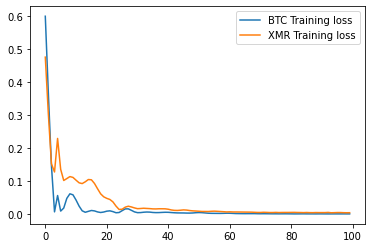

In [10]:
plt.plot(hist_btc, label="BTC Training loss ")
plt.plot(hist_xmr, label="XMR Training loss")
plt.legend()
plt.show()

In [11]:
np.shape(y_train_pred_btc), np.shape(y_train_pred_xmr)

(torch.Size([1102, 1]), torch.Size([1102, 1]))

In [12]:
# make predictions
y_test_pred_btc = model(X_test_btc)
y_test_pred_xmr = model(X_test_xmr)

future_days = 14
y_test_pred_btc_future = model(torch.cat([X_test_btc, torch.from_numpy(np.zeros_like(X_test_btc[-future_days:,]))], dim=0))
y_test_pred_xmr_future = model(torch.cat([X_test_xmr, torch.from_numpy(np.zeros_like(X_test_xmr[-future_days:,]))], dim=0))

y_test_pred_btc_future = scaler.inverse_transform(np.repeat(y_test_pred_btc_future.detach().numpy(), 2, axis=-1))
y_test_pred_xmr_future = scaler.inverse_transform(np.repeat(y_test_pred_xmr_future.detach().numpy(), 2, axis=-1))

# reshape data & invert predictions
y_train_pred_btc = scaler.inverse_transform(np.repeat(y_train_pred_btc.detach().numpy(), 2, axis=-1))
y_train_btc = scaler.inverse_transform(np.repeat(y_train_btc.detach().numpy(), 2, axis=-1))
y_test_pred_btc = scaler.inverse_transform(np.repeat(y_test_pred_btc.detach().numpy(), 2, axis=-1))
y_test_btc = scaler.inverse_transform(np.repeat(y_test_btc.detach().numpy(), 2, axis=-1))

y_train_pred_xmr = scaler.inverse_transform(np.repeat(y_train_pred_xmr.detach().numpy(), 2, axis=-1))
y_train_xmr = scaler.inverse_transform(np.repeat(y_train_xmr.detach().numpy(), 2, axis=-1))
y_test_pred_xmr = scaler.inverse_transform(np.repeat(y_test_pred_xmr.detach().numpy(), 2, axis=-1))
y_test_xmr = scaler.inverse_transform(np.repeat(y_test_xmr.detach().numpy(), 2, axis=-1))

# calculate the RMSE
train_score = math.sqrt(mean_squared_error(y_train_btc[:,0], y_train_pred_btc[:,0]))
print('Train Score BTC: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(y_test_btc[:,0], y_test_pred_btc[:,0]))
print('Test Score BTC: %.2f RMSE' % (test_score))

train_score = math.sqrt(mean_squared_error(y_train_xmr[:,0], y_train_pred_xmr[:,0]))
print('Train Score XMR: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(y_test_xmr[:,0], y_test_pred_xmr[:,0]))
print('Test Score XMR: %.2f RMSE' % (test_score))

Train Score BTC: 7.15 RMSE
Test Score BTC: 21.05 RMSE
Train Score XMR: 15.02 RMSE
Test Score XMR: 14.77 RMSE


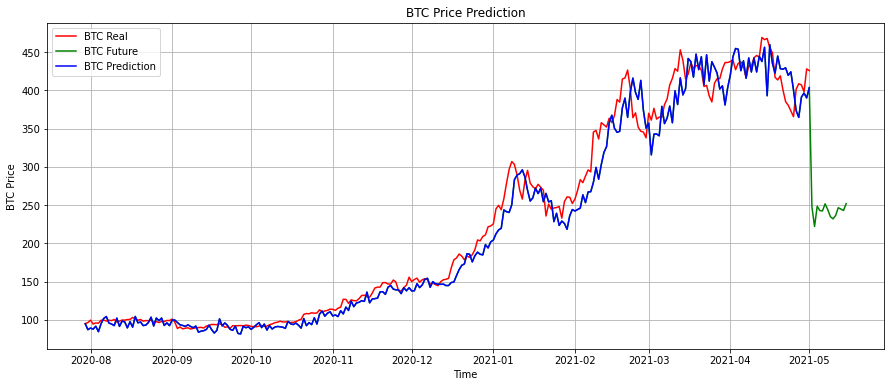

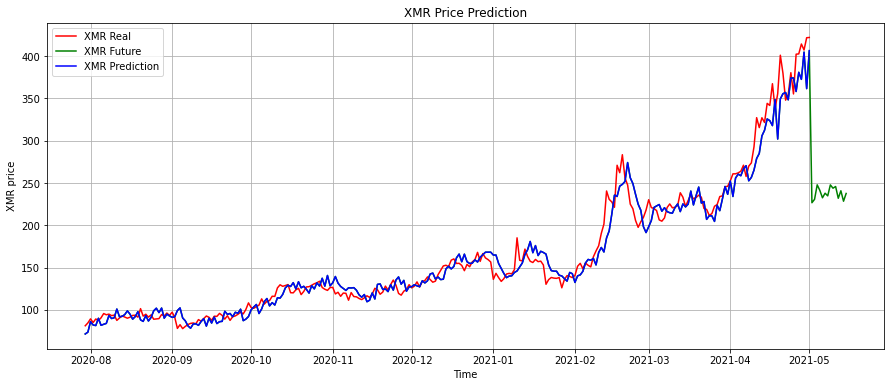

In [13]:
# Visualising the results
btc_df = btc_price[['Price']]
xmr_df = monero_price[['Price']]

date = xmr_df.index + datetime.timedelta(days=14)
future_set_btc = torch.cat([torch.from_numpy(y_test_pred_btc), torch.from_numpy(y_test_pred_btc_future[-future_days:,])], dim=0)
future_set_xmr = torch.cat([torch.from_numpy(y_test_pred_xmr), torch.from_numpy(y_test_pred_xmr_future[-future_days:,])], dim=0)

figure, axes_btc = plt.subplots(figsize=(15, 6))
axes_btc.plot(btc_df[dataset_size-len(y_test_btc):].index, y_test_btc[:,0], color = 'red', label = 'BTC Real')
axes_btc.plot(date[dataset_size-len(y_test_btc)-future_days:],future_set_btc[:,0], color = 'green', label = 'BTC Future')
axes_btc.plot(btc_df[dataset_size-len(y_test_btc):].index, y_test_pred_btc[:,0], color = 'blue', label = 'BTC Prediction')

plt.title('BTC Price Prediction')
plt.ylabel('BTC Price')
plt.xlabel('Time')
plt.legend()
plt.grid()
plt.show()

figure, axes_xmr = plt.subplots(figsize=(15, 6))
plt.plot(xmr_df[dataset_size-len(y_test_xmr):].index, y_test_xmr[:,0], color = 'red', label = 'XMR Real')
plt.plot(date[dataset_size-len(y_test_xmr)-future_days:],future_set_xmr[:,0], color = 'green', label = 'XMR Future')
plt.plot(xmr_df[dataset_size-len(y_test_xmr):].index, y_test_pred_xmr[:,0], color = 'blue', label = 'XMR Prediction')
plt.title('XMR Price Prediction')
plt.xlabel('Time')
plt.ylabel('XMR price')
plt.legend()
plt.grid()
plt.show()

